In [1]:
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.
import scipy.stats
import scipy.optimize
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc('font', size=20)
matplotlib.rc('font', family='serif')
matplotlib.rc('figure', figsize=(13, 8))
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('lines', markersize=12)
matplotlib.rc('figure.subplot', hspace=.1)
np.random.seed(0)

# Problem 2

In [3]:
# Parameters
x0, T, β = -1, 1, 5
σ = np.sqrt(2/β)

# Derivative of the external potential
drift = lambda x: - x**3 + x

# Indicator functions of which we want to calculate the expectation
def f(x):
    return (x >= 0)

def importance_sampling(b_fun, m, N, plot=False, plot_title=None):
    # N is the number of discretization points and m is the number of replicas
    # of the numerical solution

    # Time and Brownian increments
    Δt = T/N
    Δw = np.sqrt(Δt) * np.random.randn(N, m)

    # Likelihood ratio
    def g(x):
        n_paths = x.shape[1]
        result = np.zeros(n_paths)
        for i in range(N):
            bi = b_fun(x[i, :])
            result += bi * (x[i+1, :] - x[i, :] - drift(x[i, :]) * Δt) - (1/2) * bi**2 * Δt
        return np.exp(-(1/σ**2) * result)

    # We store the initial condition in x too (hence N + 1)
    x = np.zeros((N + 1, m))

    # Set initial condition
    x[0, :] = x0

    for j in range(N):
        x[j + 1] = x[j] + drift(x[j]) * Δt + b_fun(x[j]) * Δt + σ * Δw[j]

    # Evaluate target function and likelihood ratio
    fx, gx = f(x), g(x)

    estimator = np.mean(fx*gx)
    variance = np.var(fx*gx)

    if plot:
        n_samples = 20

        # Calculate colors
        colors = np.log10(gx[:n_samples])
        Max, Min = np.max(colors), np.min(colors)
        delta = Max - Min

        # Colormap
        cmap = matplotlib.cm.get_cmap('GnBu')
        colors = (colors - np.min(colors)) / delta if delta > 1e-8 else None

        # Figure
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(8, 1)

        if delta < 1e-8:
            ax_plot = fig.add_subplot(gs[:, :])
        else:
            ax_plot = fig.add_subplot(gs[:-1, :])
            ax_cb = fig.add_subplot(gs[-1, :])

        t = np.linspace(0, T, N + 1)
        ax_plot.set_xlabel('$x$')
        ax_plot.set_ylabel('$y$')
        for j in range(n_samples):
            color = cmap(colors[j]) if colors is not None else None
            ax_plot.plot(x[:, j], t, color=color)

        # 'ls' is 'linestyle' and 'c' = 'color'
        ax_plot.vlines(0, ymin=0, ymax=1)

        # Add standalone colorbar
        if delta > 1e-8:
            norm = matplotlib.colors.LogNorm(vmin=10**Min, vmax=10**Max)
            # norm = matplotlib.colors.Normalize(vmin=Min, vmax=Max)
            cb = matplotlib.colorbar.ColorbarBase(
                    ax_cb, cmap=cmap, norm=norm, orientation='horizontal')
            cb.set_label("Likelihood ratio")

        plt.show()

    return estimator, variance

def print_confidence(m, v):
    a = scipy.stats.norm.ppf(.975)
    print("95% confidence interval for P: [{:0.6f}, {:0.6f}]"
            .format(m - a*np.sqrt(v), m + a*np.sqrt(v)) +
          ", Width = {}".format(2*a*np.sqrt(v)))

# Number of samples
m = 10**3

# Additional drift to define importance distribution
b = 1.5
b_fun = lambda x: (x < 0)*b

def estimate(N):
    # Without importance sampling
    mean, var = importance_sampling(b_fun=lambda x: 0, m=m, N=N)
    print_confidence(mean, var/m)

    # With importance sampling
    mean_im, var = importance_sampling(b_fun, m=m, N=N)
    print_confidence(mean_im, var/m)

# Here the error induced by the fact that we are calculating the supremum based
# on only a finite number of discretization points dominates.
estimate(10)

95% confidence interval for P: [0.004665, 0.017699], Width = 0.013034444329235123
95% confidence interval for P: [0.009782, 0.013701], Width = 0.003919009199343104


In [4]:
# To obtain a better estimate, we reduce the time step
estimate(10**2)

95% confidence interval for P: [0.002233, 0.013015], Width = 0.010782040049494167
95% confidence interval for P: [0.008656, 0.013196], Width = 0.0045397721764685725


In [5]:
# We obtain an even better estimate by further reducing the time step
estimate(10**3)

95% confidence interval for P: [0.002313, 0.013181], Width = 0.010868337192279882
95% confidence interval for P: [0.008507, 0.012240], Width = 0.0037325068490064377


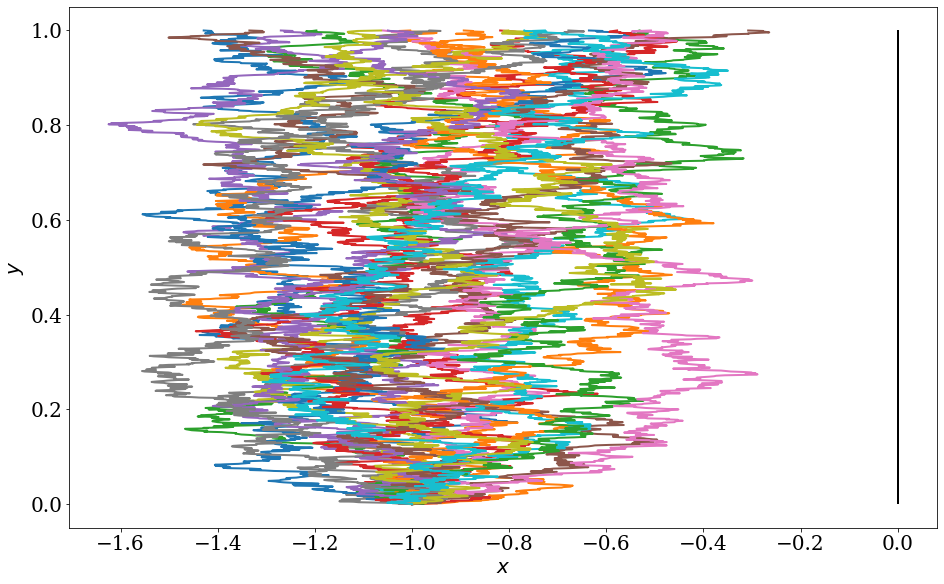

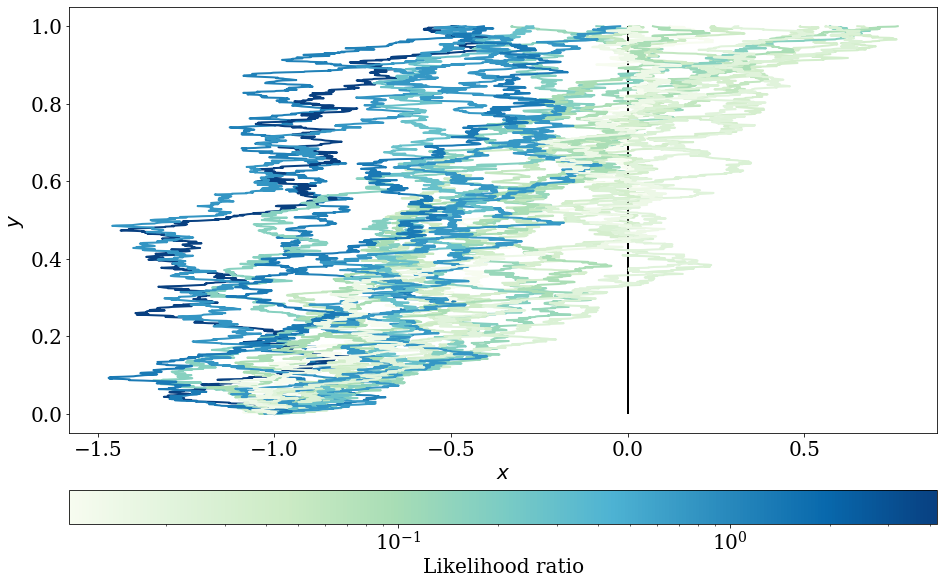

In [6]:
# Plot trajectories from nominal and importance distributions
mean, var = importance_sampling(b_fun=lambda x: 0, m=m, N=10**3, plot=True,
                                plot_title="Nominal distribution")
mean_im, var = importance_sampling(b_fun, m=m, N=10**3, plot=True,
                                   plot_title="Importance distribution")

# Problem 3

In [7]:
def euler_maruyama(drif, diff, x0, n, m, Δt):
    x = np.zeros((n + 1, m))

    # Initial condition
    x[0] = x0

    # Brownian increments
    Δw = np.sqrt(Δt) * np.random.randn(n, m)

    for i in range(n):
        if np.max(np.abs(x[i])) > 1e100: # Blow up
            return x[:i]
        x[i+1] = x[i] + drif(x[i]) * Δt + diff(x[i]) * Δw[i]

    return x

drif = lambda x, μ, σ: - μ*x*(1-x)
diff = lambda x, μ, σ: - σ*x*(1-x)
drif_prime = lambda x, μ, σ: - μ*(1-x) + μ*x

# Parameters of the equation
μ = -1

# Parameters of the simulation
n, m, Δt = 1000, 1000, .01

for σ in [.5, .6, .7, .8, .9]:
    y = euler_maruyama(
            lambda x: drif(x, μ, σ),
            lambda x: drif(x, μ, σ),
            1.1 + np.zeros(m),
            n, m, Δt)

    print(np.mean(y[-1]**2))

1.000003529666372
1.0000062042561522
1.000006674152795
1.0000054422126667
1.0000050938830782


1.5031247596321244e+99


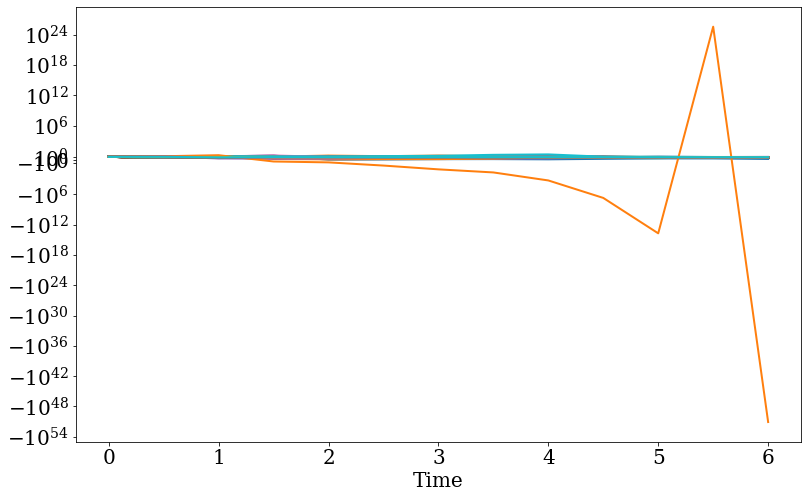

In [8]:
# Issues  can appear if Δt is too large
n, m, Δt = 1000, 1000, .5

for σ in [.5, .6, .7, .8, .9]:
    y = euler_maruyama(
            lambda x: drif(x, μ, σ),
            lambda x: drif(x, μ, σ),
            1.1 + np.zeros(m),
            n, m, Δt)

    M = np.mean(y[-1]**2)
    print(M)

    if M > 2:
        fig, ax = plt.subplots()
        t = np.linspace(0, (len(y) - 1)*Δt, len(y))
        ax.plot(t, y[:, :])
        ax.set_yscale('symlog')
        ax.set_xlabel("Time")
        plt.show()
        break

In [9]:
# Euler θ method
σ, n, m, Δt = 1, 100, 100, 1

def euler_theta(drif, diff, drif_prime, x0, n, m, Δt, θ=0):
    x = np.zeros((n + 1, m))

    # Initial condition
    x[0] = x0

    # Brownian increments
    Δw = np.sqrt(Δt) * np.random.randn(n, m)

    for i in range(n):
        if np.max(np.abs(x[i])) > 1e100: # Blow up
            return x[:i]
        for j in range(m):
            f = lambda z: x[i,j] + ((1-θ)*drif(x[i,j]) + θ*drif(z)) * Δt \
                    + diff(x[i,j]) * Δw[i,j] - z
            fprime = lambda z: θ*drif_prime(z) * Δt - 1
            result = scipy.optimize.root_scalar(f=f, fprime=fprime, x0=x[i,j])
            if result.converged:
                x[i+1,j] = result.root
    return x

for σ in [.5, .6, .7, .8, .9]:
    y = euler_theta(
            lambda x: drif(x, μ, σ),
            lambda x: drif(x, μ, σ),
            lambda x: drif_prime(x, μ, σ),
            1.1 + np.zeros(m),
            n, m, Δt, θ=.5)

    M = np.mean(y[-1]**2)
    print(M)

1.0
1.0
1.0
1.0
1.0


# Problem 6

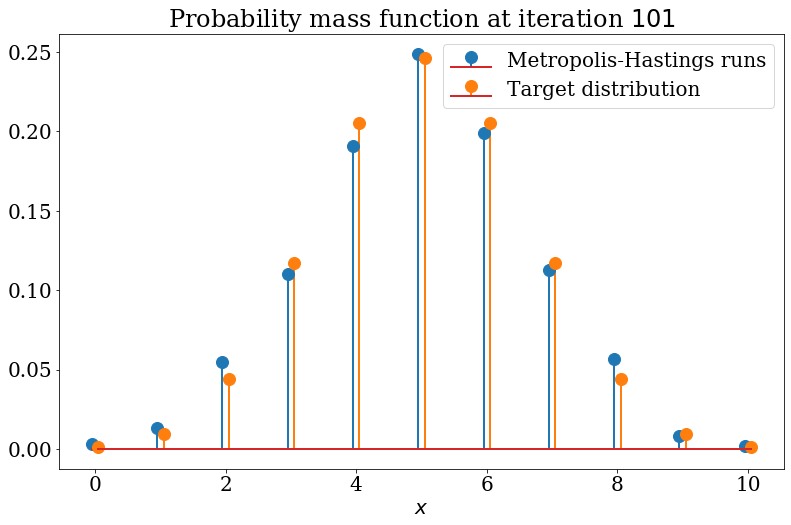

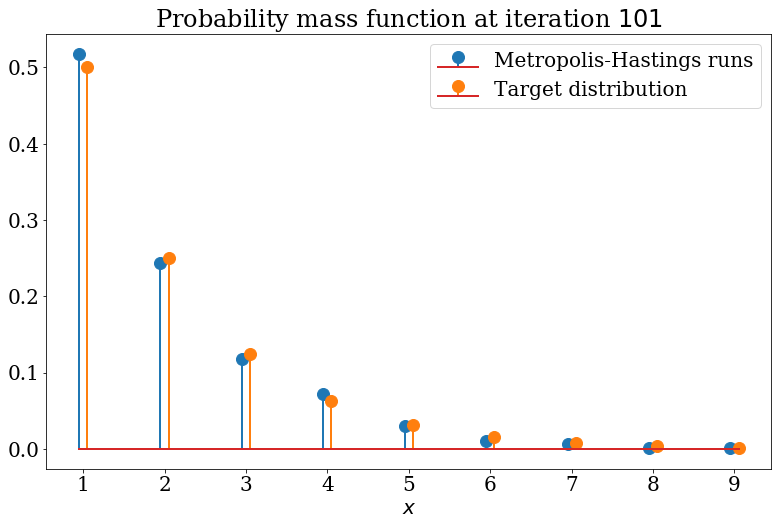

In [10]:
# This is a function frow w9
def Metropolis_Hastings(n, J, π, x0, q, q_sampler):
    # x0: Initial condition
    # n: Number of iterations
    # J: Number of particles

    # (Notice that, in fact, taking the minimum is not necessary)
    α = lambda x, y: np.minimum(1, π(y)*q(y, x) / (π(x)*q(x, y)))

    # Vector with trajectories
    x = np.zeros((n + 1, J), dtype=type(x0))

    # Initial condition
    x[0, :] = x[0, :] + x0

    for i in range(n):
        y = q_sampler(x[i])
        u = np.random.rand(J)
        x[i + 1] = np.where(u < α(x[i], y), y, x[i])

    return x

# Number of particles
J = 1000

# Number of steps
n = 100

# Size of discrete state space
N = 10

# Discrete state space
S = np.arange(N, dtype=int)

# Desired stationary distribution
f = np.math.factorial

# For the first part of the problem
def π_binomial(x, p=.5):
    return np.array([f(N)/f(k)/f(N-k)*p**k*(1-p)**(N-k) for k in x])

# Independence sampler with uniform proposal
q_indep = lambda x, y: 1/N
q_indep_sampler = lambda x: np.random.randint(0, N + 1, size=len(x))

# For the second part of the problem
def π_geometric(x, p=.5):
    result = np.array([p*(1-p)**(k-1) for k in x])
    # When x ≤ 0, π_geometric(x) should be zero.
    #
    # For π_binomial(x) above, including this additonal line was not required
    # because the proposal was always in {1, ..., N}.
    return np.where(x > 0, result, 0)

# RWMH with uniform proposal
δ = 5
q_rwmh = lambda x, y: (1/(2*δ + 1)) * (np.abs(y - x) <= δ)
q_rwmh_sampler = lambda x: (x + np.random.randint(-δ, δ, size=len(x)))

# Result
x0, mh = 1, Metropolis_Hastings
x_binomial = mh(n, J, π_binomial, x0, q_indep, q_indep_sampler)
x_geometric = mh(n, J, π_geometric, x0, q_rwmh, q_rwmh_sampler)

# Plot
for x, π in (x_binomial, π_binomial), (x_geometric, π_geometric):
    fig, ax = plt.subplots()
    ax.set_title("Probability mass function at iteration ${}$".format(len(x)))
    ax.set_xlabel("$x$")
    x_plot, y_plot = np.unique(x[-1], return_counts=True)
    ax.stem(x_plot - .05, y_plot/len(x[0]), use_line_collection=True,
            label="Metropolis-Hastings runs", linefmt='C0-', markerfmt='C0o')
    ax.stem(x_plot + .05, π(x_plot), use_line_collection=True,
            label="Target distribution", linefmt='C1-', markerfmt='C1o')
    ax.legend(loc="upper right")
    plt.show()

# Problem 8

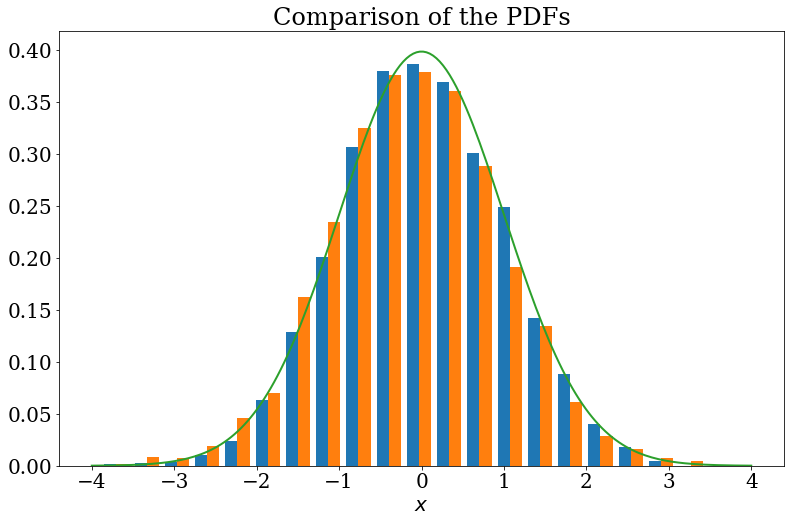

In [11]:
def Barker(n, J, π, x0, q, q_sampler):
    # x0: Initial condition
    # n: Number of iterations
    # J: Number of particles

    # (Notice that, in fact, taking the minimum is not necessary)
    α = lambda x, y: 1/(1 + π(x)*q(x, y)/(π(y)*q(y,x)))

    # Vector with trajectories
    x = np.zeros((n + 1, J), dtype=type(x0))

    # Initial condition
    x[0, :] = x[0, :] + x0

    for i in range(n):
        y = q_sampler(x[i])
        u = np.random.rand(J)
        x[i + 1] = np.where(u < α(x[i], y), y, x[i])

    return x

# Number of particles
J = 1

# Number of steps
n = 10000

π = lambda x: (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)

# RWMH with Gaussian proposal
δ = .6
# Normalization not necessary
q = lambda x, y: np.exp(-(x-y)**2/2/δ**2)
q_sampler = lambda x: x + δ*np.random.randn(len(x))

# Result
args=(n, J, π, 0., q, q_sampler)
xb, xmh = Barker(*args), Metropolis_Hastings(*args)

# Plot of the empirical PDF based on only one path,
# to check that the methods work.
fig, ax = plt.subplots()
ax.set_title("Comparison of the PDFs".format(len(x)))
ax.set_xlabel("$x$")
ax.hist(np.hstack((xmh, xb)), bins=20, density=True)
x_plot = np.linspace(-4, 4, 200)
ax.plot(x_plot, π(x_plot))
plt.show()

## Acceptance rate

In [12]:
# Store xb and xmh as one-dimensional arrays, for convenience
xb, xmh = xb[:,0], xmh[:,0]

# Note that the lines below work because we are in the case of a continuous
# state space. Indeed the probability that the proposal at step i is X[i] is
# zero, so X[i+1] == X[i] indicates a rejection. In the case of a discrete
# state space, there can be a strictly positive probability that a proposal is
# equal X[i].
n_rejected_b = np.sum(np.diff(xb) == 0)
n_rejected_mh =  np.sum(np.diff(xmh) == 0)

# The acceptance rate is higher for MH:
print((n-n_rejected_b)/n, (n-n_rejected_mh)/n)

0.463 0.8104


## Effective sample size

In [13]:
# Truncation limit for the autocorrelation function. For large k, the
# statistical error related to the calculation of ρ(k) based on one trajectory
# becomes significant, so truncation helps.
K = 1000

gammas_mh = np.zeros(K)
gammas_b = np.zeros(K)

gammas_mh[0] = np.var(xmh)
gammas_b[0] = np.var(xb)

ymh = xmh - np.mean(xmh)
yb = xb - np.mean(xb)

for k in range(1, K):
    gammas_mh[k] = np.mean(ymh[k:] * ymh[:-k])
    gammas_b[k] = np.mean(yb[k:] * yb[:-k])

rho_mh = gammas_mh / gammas_mh[0]
rho_b = gammas_b / gammas_b[0]

# Effective sample sizes
print(n/(rho_mh[0] + 2*np.sum(rho_mh[1:])))
print(n/(rho_b[0] + 2*np.sum(rho_b[1:])))

936.0104603783014
2102.894316332695


# Problem 10

In [14]:
# We redefine the function in order to be able to deal with vector input.
# We will only implement one replica.
def Metropolis_Hastings(n, π, x0, q, q_sampler):
    # x0: Initial condition
    # n: Number of iterations

    # (Notice that, in fact, taking the minimum is not necessary)
    α = lambda x, y: np.minimum(1, π(y)*q(y, x) / (π(x)*q(x, y)))

    # Vector with trajectories
    x = np.zeros((n + 1, len(x0)))

    # Initial condition
    x[0] = x0

    for i in range(n):
        y = q_sampler(x[i])
        u = np.random.rand(J)
        x[i + 1] = np.where(u < α(x[i], y), y, x[i])

    return x

μ = np.array([3, 6])
Σ = np.array([[2, .5], [.5, 1]])
Σ_inv = np.linalg.inv(Σ)

drif = lambda x: - Σ_inv.dot(x - μ)
diff = lambda x: np.sqrt(2)

def π(x):
    # Normalization constant, not necessary
    norm = (1/(2*np.pi*np.linalg.det(Σ)))
    return np.exp(-Σ_inv.dot(x-μ).dot(x-μ)/2)
    # In python, a.b.c is (a.b).c

# Normalization not necessary
δ = .1
q = lambda x, y: np.exp(-np.linalg.norm(y - x - δ*drif(x))**2/(4*δ))
q_sampler = lambda x: x + drif(x)*δ + diff(x)*np.sqrt(δ)*np.random.randn(2)

# Number of steps
n = 10000
x_mala = Metropolis_Hastings(n, π, [0., 0.], q, q_sampler)

print(np.mean(x_mala, axis=0))
print(np.cov(x_mala.T))

[3.13424793 6.01297523]
[[1.98228972 0.45910324]
 [0.45910324 0.94508608]]
